## Covid Data

Received data from [The Covid Tracking Project API](https://covidtracking.com/data/api), which separates and aggregates data across states with many helpful features. From this data, we can generate our metric of `positivityRate`, which we'll calculate as `positive` / `totalTestResults`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from datetime import datetime

In [2]:
style.use('fivethirtyeight')

In [3]:
covid_df = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv')

In [4]:
covid_df.to_csv('./data/covid_data_per_state.csv')

In [5]:
covid_df['positivityRate'] = covid_df['positive'] / covid_df['totalTestResults']

In [6]:
covid_df.isnull().sum() / covid_df.shape[0] # Showing percentage of nulls

date                           0.000000
state                          0.000000
positive                       0.009031
negative                       0.021620
pending                        0.883780
hospitalizedCurrently          0.255519
hospitalizedCumulative         0.439245
inIcuCurrently                 0.588214
inIcuCumulative                0.841544
onVentilatorCurrently          0.650702
onVentilatorCumulative         0.944353
recovered                      0.330962
dataQualityGrade               0.107827
lastUpdateEt                   0.038679
dateModified                   0.038679
checkTimeEt                    0.038679
death                          0.068327
hospitalized                   0.439245
dateChecked                    0.038679
totalTestsViral                0.432038
positiveTestsViral             0.797938
negativeTestsViral             0.843459
positiveCasesViral             0.268108
deathConfirmed                 0.616858
deathProbable                  0.731071


The reason there are so many nulls in certain columns are that The Covid Tracking Project **rendered some of those features deprecated in more recent versions of the dataset**. We won't use any of the deprecated features in our analysis

In [7]:
covid_df['datetime'] = pd.to_datetime(covid_df['date'], format=('%Y%m%d'))

In [8]:
covid_df['positivityRate'].value_counts()

0.000000    253
1.000000    112
0.003651     10
0.215385      9
0.003672      9
           ... 
0.094391      1
0.064279      1
0.101478      1
0.008379      1
0.058365      1
Name: positivityRate, Length: 9916, dtype: int64

In [9]:
# soi = states of interest
covid_df_soi = covid_df[covid_df['state'].isin(['IL', 'TX', 'GA', 'FL', 'NJ', 'NY', 'MI', 'OH'])]

### Removing unhelpful data from states

Some states had 100% positivity rate before they started testing regularly, we're removing those dates from these states below

In [10]:
covid_df_soi.loc[covid_df_soi['state'] == 'NJ', :] = covid_df_soi.loc[covid_df_soi['date'] > 20200324, :]

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
covid_df_soi.loc[covid_df_soi['state'] == 'OH', :] = covid_df_soi.loc[covid_df_soi['date'] > 20200324, :]

In [12]:
covid_df_soi.loc[covid_df_soi['state'] == 'FL', :] = covid_df_soi.loc[covid_df_soi['date'] > 20200320, :]

### Cleaning `covid_df_soi`

`covid_df_soi` = covid dataframe states of interest

In [13]:
covid_df_soi = covid_df_soi[['date', 'datetime', 'state', 'positivityRate', 'hospitalizedIncrease', 'deathIncrease', 'recovered']]

In [14]:
covid_df_soi = covid_df_soi[covid_df_soi['date'] > 20200317]

In [15]:
covid_df_soi.dropna(subset=['positivityRate'], inplace=True)

### Getting positivity rate at shutdown announcement date

In [16]:
shutdown_date_df = pd.DataFrame(columns=['positivityRateShutdown', 'positivityRateReopen', 'date_shutdown_announced', 'date_bars_reopen'], index=covid_df_soi.state.unique())

In [19]:
def find_shutdown_date(state:str, dates:list):
    # lets make some new columns that add the positivity rates during 
    # shutdown/reopening phases and dates when shutdown/reopening happened
    
    # Adding the new columns
    shutdown_date_df.loc[state, ['positivityRateShutdown', 'date_shutdown_announced']] = [covid_df.loc[((covid_df['date'] == dates[0]) & # dates[0] comes from timeline_dict below
                                                                                (covid_df['state'] == state)), # Where the state = the state from timeline_dict below
                                                                                'positivityRate'].values[0], # give us the positivity rate for the filter we just made
                                                                                # Converting items in list to datetime
                                                                                pd.to_datetime(dates[0], format='%Y%m%d')] # Add this to the date_shutdown_announced column
    
    shutdown_date_df.loc[state, ['positivityRateReopen', 'date_bars_reopen']] = [covid_df.loc[((covid_df['date'] == dates[1]) & # where the date equals dates[1]
                                                                            (covid_df['state'] == state)),  # Where state = state from timeline dict
                                                                            'positivityRate'].values[0],  # give us positivity rate
                                                                            # Converting items in list to datetime
                                                                            pd.to_datetime(dates[1], format='%Y%m%d')] # and add the date
    
                                                                                  
                                                     

In [20]:
timeline_dict = {
    'FL': [20200401, 20200605],
    'TX': [20200331, 20200518],
    'NJ': [20200316, 20200609],
    'NY': [20200322, 20200613],
    'IL': [20200320, 20200529],
    'GA': [20200402, 20200601],
    'OH': [20200322, 20200526],
    'MI': [20200323, 20200608]
}

In [21]:
for state, date in timeline_dict.items():
    find_shutdown_date(state, date)

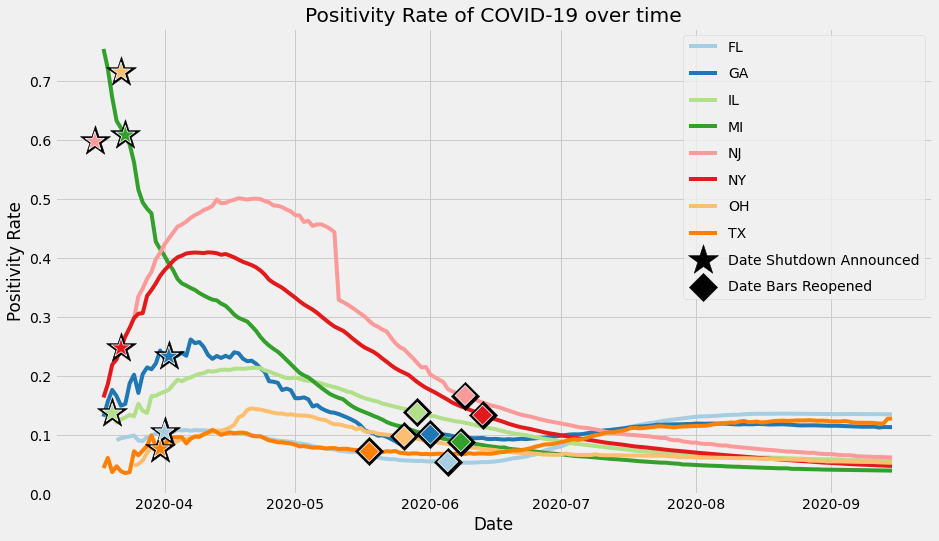

In [67]:
plt.figure(figsize=(14,8))

# Start date markers
star = plt.scatter(data=shutdown_date_df, 
                x="date_shutdown_announced", 
                y="positivityRateShutdown",
                marker="*", 
                s=1000, 
                c='black',
                label='Date Shutdown Announced',
               zorder=3)
sns.scatterplot(data=shutdown_date_df, 
                x="date_shutdown_announced", 
                y="positivityRateShutdown",
                marker="*", 
                s=400, 
                hue=shutdown_date_df.index,
                palette='Paired',
               legend=False,
               zorder=3)

# Bar reopening date markers
diamond = plt.scatter(data=shutdown_date_df, 
                x="date_bars_reopen", 
                y="positivityRateReopen",
                marker="D", 
                s=400, 
                c='black',
                label='Date Bars Reopened',
#                legend=True,
               zorder=3)
sns.scatterplot(data=shutdown_date_df, 
                x="date_bars_reopen", 
                y="positivityRateReopen",
                marker="D", 
                s=200, 
                hue=shutdown_date_df.index,
                palette='Paired',
               legend=False,
               zorder=3)



sns.lineplot(data=covid_df_soi, 
             x='datetime', 
             y='positivityRate', 
             hue=covid_df_soi['state'].tolist(),
            palette='Paired')

plt.legend(labelspacing=0.9)
plt.title('Positivity Rate of COVID-19 over time')

plt.xlabel('Date')
plt.ylabel('Positivity Rate');

*Note the stars on this plot not connected to lines belong to NJ and OH. These states had positivity rates that did not represent the natural trend at the onset of their Covid shutdown.*

#### Insights: 
* States allowed bars to reopen within a month window around the beginning of June
* States whose **positivity rates went down** after reopening bars include: OH, NY, IL, MI, and NJ
* States whose **positivity rates went up** after reopening include: TX, FL, and GA
* There was large drop in positivity rate after a spike in New Jersey test results being added to the dataset around May 10


Future steps - Some states had second shutdowns after reopening, we'd like to look at when those dates occured and add them to the visual


In [345]:
nj_tests = covid_df[covid_df['state'] == 'NJ'][['totalTestResultsIncrease', 'state', 'datetime']]

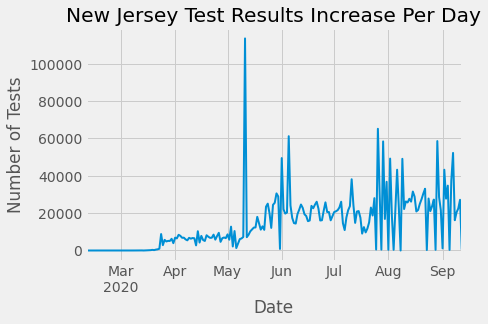

In [352]:
nj_tests.plot(x='datetime', y='totalTestResultsIncrease', legend=False, linewidth=2)
plt.title('New Jersey Test Results Increase Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Tests');

We were curious about the dramatic drop in positivity rate that New Jersey had, it looks like **a lot of test results were delivered around May 10, 2020**, which is likely the cause for that drop in positivity rate

## **What's next?**

We have our data! Time to run some sentiment analysis on it.